# PREVALÊNCIA

Prevalência = (Casos atuais da doença em um dado momento) / (Número de pessoas em risco de contrair a doença)

Nosso objetivo -> prevalência para cada 100 mil habitantes

Como fazer -> numero de casos acumulados por semana epidemiológica, dividir pela população e multiplicar por 100.000


### 1 - Preparar base de dados 
##### Coletar na base de dados disponibilizada as informações referentes ao indicador Epidemiológico do grupo

A) Abrir dataframe

B) Tratar dados faltantes ou em formato incorreto

C) Eliminar colunas desnecessárias

D) Guarda as datas do último dia de cada semana epidemiológica (usado mais tarde)

E) Calcula a população por estado (base pop2020)

F) Separa os estados por regiões (ainda não agregados)

G) Adiciona uma coluna com os casos confirmados para cada semana ep.

H) Agrega os numeros de casos e a população de acordo com a região

I) Realiza o cálculo da prevalência de cada região em cada semana ep.

J) Calculo e inclusão da prevalência do total do Brasil


### A) Abrir dataframes (caso_full e pop2020)

In [1]:
import pandas as pd

df_tabela_inteira = pd.read_csv("caso_full.csv")

df_pop_mun = pd.read_csv("pop2020.csv")
df_pop_mun = df_pop_mun.rename(columns={"Armenor": "city_ibge_code"})


pd.set_option("display.max_colwidth", 100000)
pd.set_option('display.max_rows', 200)


#df_pop_mun
#df_tabela_inteira

### B) Tratar dados faltantes ou em formato incorreto

In [2]:
df_tabela_inteira.dropna(axis=0,subset=['city_ibge_code'],inplace=True) #retira linhas sem o código da cidade
df_tabela_inteira = df_tabela_inteira.astype({'city_ibge_code':int},copy=False) #transforma os códigos da cidade em inteiro
df_tabela_inteira = df_tabela_inteira.astype({'last_available_confirmed':int},copy=False) #transforma o num de confirmados em inteiro

#substitui os NaN de uma coluna por 0
df_tabela_inteira['last_available_confirmed_per_100k_inhabitants'] = df_tabela_inteira['last_available_confirmed_per_100k_inhabitants'].fillna(0)

#df_tabela_inteira.loc[df_tabela_inteira['date'] == "2020-03-12"]


### C) Une casos_full com pop2020 e elimina colunas desnecessárias

In [3]:
#Uni casos_full com pop2020 de acordo com valores iguais na coluna 'city_ibge_code'
df_tab_reduzida = pd.merge(df_tabela_inteira,df_pop_mun, on ='city_ibge_code',how='outer')

#Remove colunas desnecessarias
df_tab_reduzida = df_tab_reduzida.drop(columns=['is_last', 'is_repeated', 'new_confirmed', 'new_deaths', 'last_available_death_rate', 'order_for_place','last_available_deaths', 'last_available_confirmed_per_100k_inhabitants','estimated_population_2019','Unnamed: 0', 'ARmaior', 'NomeMunic', 'ano'])
df_tab_reduzida.dropna(axis=0,subset=['place_type'],inplace=True)
df_tab_reduzida.rename(columns={'Total':'pop2020'}, inplace=True)
df_tab_reduzida.head(6)

,city,city_ibge_code,date,epidemiological_week,last_available_confirmed,last_available_date,place_type,state,pop2020
0,São Paulo,3550308,2020-02-25,9.0,1.0,2020-02-25,city,SP,12142621.23
1,São Paulo,3550308,2020-02-26,9.0,1.0,2020-02-26,city,SP,12142621.23
2,São Paulo,3550308,2020-02-27,9.0,1.0,2020-02-27,city,SP,12142621.23
3,São Paulo,3550308,2020-02-28,9.0,2.0,2020-02-28,city,SP,12142621.23
4,São Paulo,3550308,2020-02-29,9.0,2.0,2020-02-29,city,SP,12142621.23
5,São Paulo,3550308,2020-03-01,10.0,2.0,2020-03-01,city,SP,12142621.23


### D) Guarda as datas do último dia de cada semana epidemiológica (usado mais tarde)


In [4]:
#cria lista com a última data de cada semana epidemiológica (por algum motivo usa sao paulo como parametro. deve ser pq é a cidade que aparece desde o inicio)
ultimo_dia_semana = list(df_tab_reduzida[df_tab_reduzida['city']=='São Paulo'].groupby('epidemiological_week')['date'].agg(lambda x:x[x.last_valid_index()]).values)
ultimo_dia_semana

['2020-02-29',
 '2020-03-07',
 '2020-03-14',
 '2020-03-21',
 '2020-03-28',
 '2020-04-04',
 '2020-04-11',
 '2020-04-18',
 '2020-04-25',
 '2020-05-02',
 '2020-05-09',
 '2020-05-16',
 '2020-05-23',
 '2020-05-30',
 '2020-06-06',
 '2020-06-13',
 '2020-06-20',
 '2020-06-27',
 '2020-07-04',
 '2020-07-11',
 '2020-07-18',
 '2020-07-25',
 '2020-08-01',
 '2020-08-08',
 '2020-08-15',
 '2020-08-19']

### E) Calcula a população por estado (base pop2020)

In [5]:
#Calcula a população por estado
df_states = df_pop_mun.groupby('ARmaior')[['Total']].sum()
est_dict = {'ACRE': 'AC','ALAGOAS': 'AL','AMAPÁ': 'AP','AMAZONAS': 'AM','BAHIA': 'BA','CEARÁ': 'CE','DISTRITO FEDERAL': 'DF','ESPÍRITO SANTO': 'ES','GOIÁS': 'GO','MARANHÃO': 'MA','MATO GROSSO': 'MT','MATO GROSSO DO SUL': 'MS','MINAS GERAIS': 'MG','PARÁ': 'PA','PARAÍBA': 'PB','PARANÁ': 'PR','PERNAMBUCO': 'PE','PIAUÍ': 'PI','RIO DE JANEIRO': 'RJ','RIO GRANDE DO NORTE': 'RN','RIO GRANDE DO SUL': 'RS','RONDÔNIA': 'RO','RORAIMA': 'RR','SANTA CATARINA': 'SC','SÃO PAULO': 'SP','SERGIPE': 'SE','TOCANTINS': 'TO'}
df_states.rename(index=est_dict, inplace=True)
df_states.rename_axis('state', inplace=True)
df_states.rename(columns={'Total': 'pop2020'}, inplace=True)

df_states.head(3)

,pop2020
state,
AC,8.944700e+05
AL,3.351092e+06
AP,8.617730e+05


In [7]:
#união da população de cada estado com os outros dados de casos_full

tab_states = df_tab_reduzida[df_tab_reduzida['place_type']=='state']
tab_states = tab_states.drop(columns=['pop2020'])
tab_states = pd.merge(tab_states,df_states, on ='state',how='outer')

tab_states.head(4)

,city,city_ibge_code,date,epidemiological_week,last_available_confirmed,last_available_date,place_type,state,pop2020
0,NaN,35,2020-02-25,9.0,1.0,2020-02-25,state,SP,4.628933e+07
1,NaN,35,2020-02-26,9.0,1.0,2020-02-26,state,SP,4.628933e+07
2,NaN,35,2020-02-27,9.0,1.0,2020-02-27,state,SP,4.628933e+07
3,NaN,35,2020-02-28,9.0,2.0,2020-02-28,state,SP,4.628933e+07


### F) Separa os estados por regiões (ainda não agregados)

In [8]:

##Adiciona a coluna de região, classificando cada estado
df_states["regiao"] = None
for index, row in df_states.iterrows(): 

    
    if index in ['AC','AM','AP','TO','PA','RO','RR']:
        df_states.loc[index,'regiao']='Norte'
        
    elif index in ['AL','BA','CE','MA','PB','PE','PI','RN','SE']:
        df_states.loc[index,'regiao']='Nordeste'
        
    elif index in ['GO','MS','MT', 'DF']:
        df_states.loc[index,'regiao']='Centro Oeste'
        
    elif index in['ES','MG','RJ','SP']:
        df_states.loc[index,'regiao']='Sudeste'
        
    elif index in['PR','RS','SC']:
        df_states.loc[index,'regiao']='Sul'
    
    
df_states.head(4)

,pop2020,regiao
state,,
AC,8.944700e+05,Norte
AL,3.351092e+06,Nordeste
AP,8.617730e+05,Norte
AM,4.207714e+06,Norte


### G) Adiciona uma coluna com os casos confirmados para cada semana ep.

In [9]:
#Confirmados para cada semana epidemiológica (o nome das colunas está como prevalência, mas ela ainda não foi calculada)

##DEFINIÇÃO DAS SEM EPIDEMIOLOGICAS USADAS
semanas = range(9,32)#limite (9,35)

for x in semanas:   
    
    semana_epidemiologica = tab_states[tab_states['epidemiological_week']==x]
    
    semana_epidemiologica_estado = semana_epidemiologica.groupby('state')['last_available_confirmed']
    
    prevalencia_semana = semana_epidemiologica_estado.agg(lambda x:x[x.last_valid_index().astype(int)])
    
    df_states['prevalencia_semana{}'.format(x)] = prevalencia_semana.astype(int)
      
    #-----------------------------------------------------------------------#    
    
df_states = df_states.fillna(0)
df_states.head(4)

,pop2020,regiao,prevalencia_semana9,prevalencia_semana10,prevalencia_semana11,prevalencia_semana12,prevalencia_semana13,prevalencia_semana14,prevalencia_semana15,prevalencia_semana16,...,prevalencia_semana22,prevalencia_semana23,prevalencia_semana24,prevalencia_semana25,prevalencia_semana26,prevalencia_semana27,prevalencia_semana28,prevalencia_semana29,prevalencia_semana30,prevalencia_semana31
state,,,,,,,,,,,,,,,,,,,,,
AC,8.944700e+05,Norte,0.0,0.0,0.0,11,25,46,72,142,...,6072,7525,9534,11263,12913,14487,16080,17202,18657,19930
AL,3.351092e+06,Nordeste,0.0,0.0,1.0,7,14,23,48,132,...,9223,14818,20887,27698,33521,39255,44633,49583,54730,60992
AP,8.617730e+05,Norte,0.0,0.0,0.0,1,4,29,193,400,...,9313,12773,16322,21574,27901,29809,31279,33585,35162,36595
AM,4.207714e+06,Norte,0.0,0.0,2.0,11,111,311,1049,1897,...,40560,48785,56026,62579,69022,75502,83230,90534,96094,101777


### H) Agrega os numeros de casos e a população de acordo com a região

In [10]:
df_reg_pop = df_states.groupby('regiao').sum()
df_reg_pop.head(4)

,pop2020,prevalencia_semana9,prevalencia_semana10,prevalencia_semana11,prevalencia_semana12,prevalencia_semana13,prevalencia_semana14,prevalencia_semana15,prevalencia_semana16,prevalencia_semana17,...,prevalencia_semana22,prevalencia_semana23,prevalencia_semana24,prevalencia_semana25,prevalencia_semana26,prevalencia_semana27,prevalencia_semana28,prevalencia_semana29,prevalencia_semana30,prevalencia_semana31
regiao,,,,,,,,,,,,,,,,,,,,,
Centro Oeste,1.650430e+07,0.0,1.0,14.0,144,358,681,1022,1506,1989,...,16985,27661,39072,62187,86286,114708,146402,171100,214521,256896
Nordeste,5.737424e+07,0.0,2.0,17.0,191,655,1680,4048,8804,16823,...,174737,238429,301278,374714,452053,541509,623441,694499,784418,872782
Norte,1.867259e+07,0.0,0.0,2.0,32,189,537,1689,3463,7114,...,106002,141817,175817,211496,254583,287964,320156,351162,385545,413676
Sudeste,8.901224e+07,2.0,16.0,88.0,596,2230,6308,12159,20613,30024,...,182629,238971,298336,372873,457002,541740,632771,708263,822465,933330


### I) Realiza o cálculo da prevalência de cada região em cada semana ep.

In [11]:
###Alterando valores para a PREVALENCIA
##Apesar dos titulos das colunas estarem prevalencia, os valores iniciais se referiam 


#função que recebe uma série (linha do dataframe) e retorna uma lista com os novos valores de cada linha
def calc_prev(serie):
    
    lst_valores = []
    lst_valores.append(serie['pop2020'])
    
    for x in semanas:        
        
        #O cálculo da prevalência acontece aqui
        prev = (serie["prevalencia_semana{}".format(x)])/(serie['pop2020'])*100000
        lst_valores.append(prev)
    
    
    return lst_valores

#--------------------------------------------------------------------#

#'axis=1' manda series com as LINHAS para a função a ser aplicada
#'broadcast' mantém o nome das colunas
df_reg = df_reg_pop.apply(calc_prev, axis=1, result_type='broadcast') 

df_reg = df_reg.drop(columns=['pop2020'])

df_reg.head(4)

,prevalencia_semana9,prevalencia_semana10,prevalencia_semana11,prevalencia_semana12,prevalencia_semana13,prevalencia_semana14,prevalencia_semana15,prevalencia_semana16,prevalencia_semana17,prevalencia_semana18,...,prevalencia_semana22,prevalencia_semana23,prevalencia_semana24,prevalencia_semana25,prevalencia_semana26,prevalencia_semana27,prevalencia_semana28,prevalencia_semana29,prevalencia_semana30,prevalencia_semana31
regiao,,,,,,,,,,,,,,,,,,,,,
Centro Oeste,0.000000,0.006059,0.084826,0.872500,2.169131,4.126197,6.192325,9.124893,12.051403,18.352790,...,102.912556,167.598717,236.738262,376.792646,522.809112,695.018748,887.053516,1036.699338,1299.788304,1556.539528
Nordeste,0.000000,0.003486,0.029630,0.332902,1.141627,2.928143,7.055431,15.344865,29.321520,50.691736,...,304.556523,415.568010,525.110196,653.104913,787.902334,943.818988,1086.621743,1210.471743,1367.195379,1521.208740
Norte,0.000000,0.000000,0.010711,0.171374,1.012179,2.875873,9.045344,18.545900,38.098623,69.342278,...,567.687689,759.492886,941.577954,1132.654812,1363.404792,1542.174841,1714.577268,1880.628140,2064.764343,2215.418315
Sudeste,0.002247,0.017975,0.098863,0.669571,2.505273,7.086666,13.659919,23.157489,33.730193,52.629841,...,205.172907,268.469820,335.162896,418.900818,513.414786,608.612930,710.880888,795.691696,923.990906,1048.541193


### J) Calculo e inclusão da prevalência do total do Brasil

In [12]:
#---------total de casos confirmados----#
tab_states = df_tab_reduzida[df_tab_reduzida['place_type']=='state']
total_confirmed = tab_states[tab_states['date'].isin(ultimo_dia_semana)].groupby('epidemiological_week')['last_available_confirmed'].agg(sum)

#-------- População total (soma das regiões)---------#
total_pop = df_reg_pop['pop2020'].sum()

In [13]:
total_values = total_confirmed.tolist() #lista com o total de casos por semana para o Brasil
column_keys = ['prevalencia_semana{}'.format(i) for i in semanas] #lista com o nome de cada coluna de cada semana

#A prevalência para o Brasil é calculada aqui:
dict_data = {column_keys[i]: ((total_values[i]/total_pop)*100000) for i in range(len(column_keys))} 

#criando dataframe para o Brasil
df_br = pd.DataFrame(data=dict_data, index=['Brasil'])
df_br


,prevalencia_semana9,prevalencia_semana10,prevalencia_semana11,prevalencia_semana12,prevalencia_semana13,prevalencia_semana14,prevalencia_semana15,prevalencia_semana16,prevalencia_semana17,prevalencia_semana18,...,prevalencia_semana22,prevalencia_semana23,prevalencia_semana24,prevalencia_semana25,prevalencia_semana26,prevalencia_semana27,prevalencia_semana28,prevalencia_semana29,prevalencia_semana30,prevalencia_semana31
Brasil,0.000944,0.008973,0.064225,0.534578,1.866774,4.902348,9.912839,17.555608,28.101252,46.01057,...,237.496804,319.657524,402.246095,505.930675,622.675589,746.162234,870.962658,981.298299,1132.90603,1280.717405


In [14]:
df_reg_brasil = pd.concat([df_reg, df_br])
df_reg_brasil

,prevalencia_semana9,prevalencia_semana10,prevalencia_semana11,prevalencia_semana12,prevalencia_semana13,prevalencia_semana14,prevalencia_semana15,prevalencia_semana16,prevalencia_semana17,prevalencia_semana18,...,prevalencia_semana22,prevalencia_semana23,prevalencia_semana24,prevalencia_semana25,prevalencia_semana26,prevalencia_semana27,prevalencia_semana28,prevalencia_semana29,prevalencia_semana30,prevalencia_semana31
Centro Oeste,0.000000,0.006059,0.084826,0.872500,2.169131,4.126197,6.192325,9.124893,12.051403,18.352790,...,102.912556,167.598717,236.738262,376.792646,522.809112,695.018748,887.053516,1036.699338,1299.788304,1556.539528
Nordeste,0.000000,0.003486,0.029630,0.332902,1.141627,2.928143,7.055431,15.344865,29.321520,50.691736,...,304.556523,415.568010,525.110196,653.104913,787.902334,943.818988,1086.621743,1210.471743,1367.195379,1521.208740
Norte,0.000000,0.000000,0.010711,0.171374,1.012179,2.875873,9.045344,18.545900,38.098623,69.342278,...,567.687689,759.492886,941.577954,1132.654812,1363.404792,1542.174841,1714.577268,1880.628140,2064.764343,2215.418315
Sudeste,0.002247,0.017975,0.098863,0.669571,2.505273,7.086666,13.659919,23.157489,33.730193,52.629841,...,205.172907,268.469820,335.162896,418.900818,513.414786,608.612930,710.880888,795.691696,923.990906,1048.541193
Sul,0.000000,0.000000,0.049682,0.559745,1.725605,3.891719,6.865986,9.237450,11.777832,18.289422,...,74.721001,99.412715,123.461881,165.826966,227.299563,311.734957,402.562706,506.522935,636.069146,779.363889
Brasil,0.000944,0.008973,0.064225,0.534578,1.866774,4.902348,9.912839,17.555608,28.101252,46.010570,...,237.496804,319.657524,402.246095,505.930675,622.675589,746.162234,870.962658,981.298299,1132.906030,1280.717405


In [15]:
#Salva a tabela de prevalência por região
df_reg_brasil.to_csv('prevalencia_estado_semana.csv')

# 2 - Gráficos
##### Plotar Gráficos com a Evolução Temporal do Indicador Epidemiológico do grupo

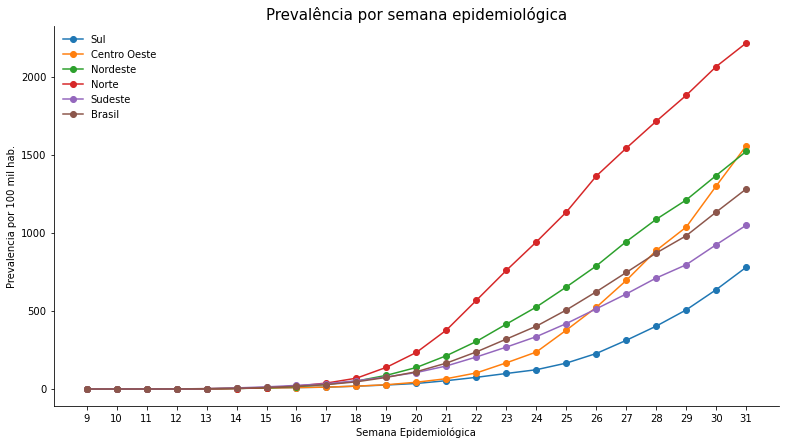

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

semanas = range(9,32) ##define quantos pontos serão colocados no eixo X

plt.figure(figsize=(13,7))

plt.plot(df_reg_brasil.T[['Sul', 'Centro Oeste', 'Nordeste', 'Norte', 'Sudeste', 'Brasil']],'-o')
plt.title('Prevalência por semana epidemiológica',fontsize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.ylabel('Prevalencia por 100 mil hab.')
plt.xlabel('Semana Epidemiológica')

plt.xticks(range(len(semanas)),semanas)
plt.legend(['Sul', 'Centro Oeste', 'Nordeste', 'Norte', 'Sudeste', 'Brasil'], frameon=False)
fig = plt.gcf()
fig.savefig('Prevalencia_CO.svg', format='svg')

plt.show()


# 3 - Mapas
##### Plotar Mapas de cada Semana Epidemiológica de forma a ver a Evolução Temporal do Indicador Epidemiológico do grupo

In [ ]:
len(semanas)